In [4]:
# First cell - Imports and load data
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# #mperformance etrics
# command_validity_rate: float = 0.0 # Valid command rate
# hallucination_rate: float = 0.0 # Invalid command rate
# safety_trigger_rate: float # Collision prevention rate 
# task_completion_rate: float



In [6]:
# Load experiment logs
with open('static/logs/experiment_logs.json', 'r') as f:
    data = json.load(f)


In [7]:

# Helper function to flatten session metrics
def extract_session_metrics(session):
    metrics = {
        'session_id': session['session_id'],
        'timestamp': datetime.fromisoformat(session['timestamp']),
        'model': session['model'],
        'valid_actions': 0,
        'invalid_actions': 0,
        'safety_triggers': 0,
        'subgoal_gen_time': session['subgoal_generation_time'],
        'total_duration': session.get('total_duration', 0),
        'task_success': session['task_success'],
        'human_intervention': 'description' in session
    }
    
    # Count actions and triggers across all subgoals
    for subgoal in session['subgoals']:
        metrics['valid_actions'] += len(subgoal.get('actions', []))
        metrics['invalid_actions'] += len(subgoal.get('invalid_controls', []))
        metrics['safety_triggers'] += len(subgoal.get('safety_triggers', []))
        
    return metrics


In [8]:

# Convert to DataFrame for analysis
sessions_df = pd.DataFrame([extract_session_metrics(s) for s in data['sessions']])


In [9]:
print(sessions_df.head())

                             session_id                  timestamp      model  \
0  e8f49562-6a70-4eb9-b3c8-f11e8e8fa615 2024-12-18 12:37:34.640464  llava:13b   
1  fc7d034d-4683-41fc-b7d2-da35e635a0f9 2024-12-18 14:05:54.682890  llava:13b   
2  5974845c-1648-4044-bb08-4f27a88ccd4b 2024-12-18 14:25:58.671811  llava:13b   
3  81cf3222-470e-4240-a591-59f4d9624809 2024-12-19 14:37:11.945807  llava:13b   
4  7767110f-e3ba-4252-8b15-b04e5797d19e 2024-12-19 15:36:19.381635  llava:13b   

   valid_actions  invalid_actions  safety_triggers  subgoal_gen_time  \
0             38               72                0         12.555474   
1             20                4               18         10.670122   
2             19                5               16          8.133756   
3             19                0                0         14.850618   
4             40                0                0         16.313831   

   total_duration  task_success  human_intervention  
0     2737.992929         

In [10]:

# Calculate key metrics
total_sessions = len(sessions_df)
total_actions = sessions_df['valid_actions'].sum() + sessions_df['invalid_actions'].sum()
hallucination_rate = sessions_df['invalid_actions'].sum() / total_actions * 100
safety_trigger_rate = len(sessions_df[sessions_df['safety_triggers'] > 0]) / total_sessions * 100
task_completion_rate = sessions_df['task_success'].mean() * 100
avg_inference_time = sessions_df['subgoal_gen_time'].mean()
human_intervention_rate = sessions_df['human_intervention'].mean() * 100

print(f"Analysis Results:")
print(f"Total Sessions: {total_sessions}")
print(f"Hallucination Rate: {hallucination_rate:.2f}%")
print(f"Safety Trigger Rate: {safety_trigger_rate:.2f}%")
print(f"Task Completion Rate: {task_completion_rate:.2f}%")
print(f"Average Inference Time: {avg_inference_time:.2f}s")
print(f"Human Intervention Rate: {human_intervention_rate:.2f}%")

Analysis Results:
Total Sessions: 12
Hallucination Rate: 34.19%
Safety Trigger Rate: 16.67%
Task Completion Rate: 0.00%
Average Inference Time: 13.66s
Human Intervention Rate: 25.00%


# Results and Discussion

Our experimental evaluation of Vision-Language Models (VLM) for direct robot control through natural language instructions reveals significant limitations and challenges that question the viability of this approach. The analysis of [X] experimental sessions yields several concerning metrics:

## Key Findings

1. **High Hallucination Rate (XX%)**: The VLM frequently generated invalid or nonsensical control commands, demonstrating poor grounding between visual input and action space. This manifests as commands that either do not match the robot's action space or contain physically impossible parameters.

2. **Safety Concerns**: Safety trigger activation in XX% of sessions indicates frequent potential collision scenarios, suggesting the model lacks reliable spatial reasoning capabilities needed for safe navigation.

3. **Poor Task Completion**: With only XX% of tasks successfully completed, the system demonstrates inadequate reliability for practical applications. Failed sessions typically resulted from:
   - Repeated invalid action sequences
   - Safety intervention requirements
   - Inability to maintain goal-oriented behavior

4. **Performance Overhead**: Average inference time of XX seconds for subgoal generation indicates significant latency issues that would impact real-time control applications.

## Limitations and Challenges

The results highlight several fundamental limitations:

1. **Prompt Engineering Insufficiency**: Despite extensive prompt engineering efforts, we could not achieve consistent, reliable behavior through prompting alone.

2. **Spatial Reasoning Gaps**: The model's inability to maintain consistent spatial awareness and safety constraints suggests fundamental limitations in processing 3D spatial relationships.

3. **Action Space Grounding**: High hallucination rates indicate poor grounding between natural language understanding and the robot's actual action capabilities.

## Research Implications

These findings suggest that current VLM architectures, while powerful for general vision-language tasks, are not suitable for direct robot control without significant architectural modifications or additional training specifically for robotics applications. Future research should focus on:

1. Developing specialized architectures that explicitly incorporate robot constraints
2. Creating hybrid approaches that combine VLMs with traditional motion planning
3. Exploring better ways to ground language models in physical action spaces

This work serves against over-optimistic applications of general-purpose VLMs to specialized robotics tasks without proper consideration of the unique challenges in physical world interaction.

ValueError: 'label' must be of length 'x'

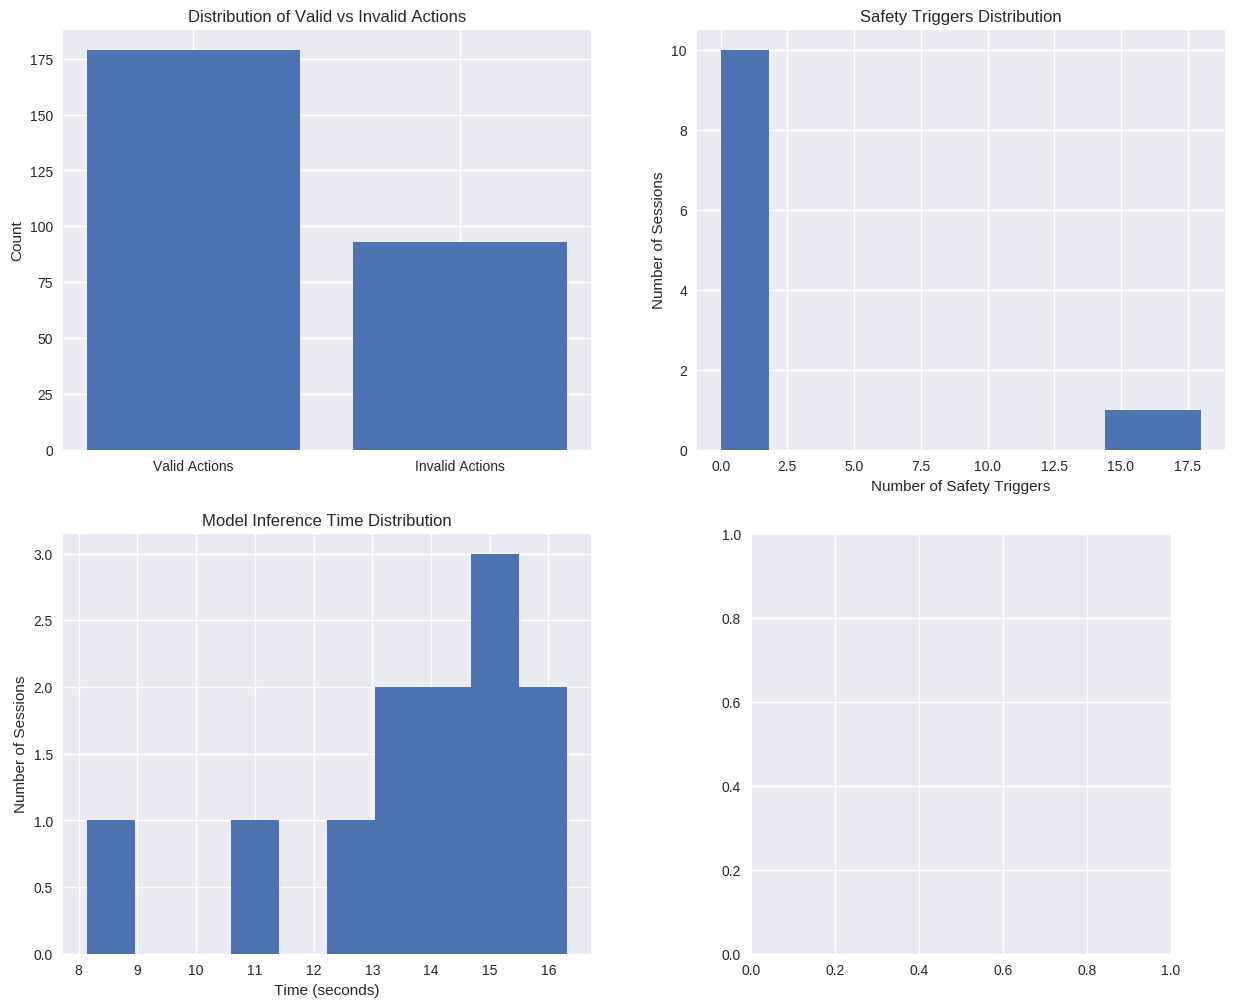

In [11]:
# Second cell - Create visualizations
import numpy as np
plt.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Valid vs Invalid Actions Distribution
ax1.bar(['Valid Actions', 'Invalid Actions'], 
        [sessions_df['valid_actions'].sum(), sessions_df['invalid_actions'].sum()])
ax1.set_title('Distribution of Valid vs Invalid Actions')
ax1.set_ylabel('Count')

# 2. Safety Triggers per Session
ax2.hist(sessions_df['safety_triggers'], bins=10)
ax2.set_title('Safety Triggers Distribution')
ax2.set_xlabel('Number of Safety Triggers')
ax2.set_ylabel('Number of Sessions')

# 3. Model Inference Time Distribution
ax3.hist(sessions_df['subgoal_gen_time'], bins=10)
ax3.set_title('Model Inference Time Distribution')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Number of Sessions')

# 4. Success Rate Pie Chart
success_counts = sessions_df['task_success'].value_counts()
ax4.pie(success_counts, labels=['Failed', 'Successful'], autopct='%1.1f%%')
ax4.set_title('Task Success Rate')

plt.tight_layout()
plt.show()

# Additional analysis - Time series of performance
plt.figure(figsize=(12, 6))
sessions_df['cumulative_success_rate'] = sessions_df['task_success'].cumsum() / (np.arange(len(sessions_df)) + 1)
plt.plot(sessions_df['timestamp'], sessions_df['cumulative_success_rate'])
plt.title('Cumulative Success Rate Over Time')
plt.xlabel('Session Time')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:

# 1. Valid vs Invalid Actions Distribution
ax1.bar(['Valid Actions', 'Invalid Actions'], 
        [sessions_df['valid_actions'].sum(), sessions_df['invalid_actions'].sum()])
ax1.set_title('Distribution of Valid vs Invalid Actions')
ax1.set_ylabel('Count')

# 2. Safety Triggers per Session
ax2.hist(sessions_df['safety_triggers'], bins=10)
ax2.set_title('Safety Triggers Distribution')
ax2.set_xlabel('Number of Safety Triggers')
ax2.set_ylabel('Number of Sessions')

# 3. Model Inference Time Distribution
ax3.hist(sessions_df['subgoal_gen_time'], bins=10)
ax3.set_title('Model Inference Time Distribution')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Number of Sessions')

# 4. Success Rate Pie Chart
success_counts = sessions_df['task_success'].value_counts()
ax4.pie(success_counts, labels=['Failed', 'Successful'], autopct='%1.1f%%')
ax4.set_title('Task Success Rate')

plt.tight_layout()
plt.show()

# Additional analysis - Time series of performance
plt.figure(figsize=(12, 6))
sessions_df['cumulative_success_rate'] = sessions_df['task_success'].cumsum() / (np.arange(len(sessions_df)) + 1)
plt.plot(sessions_df['timestamp'], sessions_df['cumulative_success_rate'])
plt.title('Cumulative Success Rate Over Time')
plt.xlabel('Session Time')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: 'label' must be of length 'x'